In [3]:
import cv2
import numpy as np   
import matplotlib.pyplot as plt     

In [4]:
def draw_bboxes(img,bboxes,color,th=1):
    img_ = img.copy()
    for bbox in bboxes:
        x,y,w,h = bbox
        pt1 = (int(x-w/2),int(y-h/2))
        pt2 = (int(x+w/2),int(y+h/2))
        img_ =cv2.rectangle(img_,pt1,pt2,color,thickness = th)
    return img_


In [5]:
def flip(src,labels):
    w = src.shape[1]
    dst = cv2.flip(src,1)
    labels[:,1] = w-1-labels[:,1]
    return dst,labels
def pad_to_square(img):
        h,w,_= img.shape
        ts = max(h,w)
        diff1 = abs(h-ts)
        diff2 = abs(w-ts)
        pad = (diff1//2,diff2//2,diff1-diff1//2,diff2-diff2//2)
        img = cv2.copyMakeBorder(img,pad[0],pad[2],pad[1],pad[3],cv2.BORDER_CONSTANT,0)
        return img,(pad[0],pad[1])





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(2, 5)


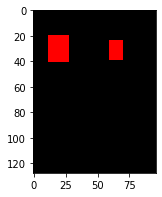

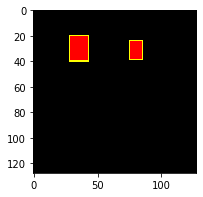

In [7]:
img = np.zeros([128,96,3])
labels = np.array([[0,20,30,15,20],[0,64,32,10,15]])
print(labels.shape)
img = draw_bboxes(img,labels[:,1:],(255,0,0),-1)
plt.figure(figsize=(3,3))
plt.imshow(img)
img_,pad = pad_to_square(img)
labels[:,1]+=pad[1]
labels[:,2]+=pad[0]
plt.figure(figsize=(3,3))
img_ = draw_bboxes(img_,labels[:,1:],(255,255,0),1)
plt.imshow(img_)


